# Task 2 - Network-Wide Anomaly Event Detection and Diagnosis (PCA-APD)

Welcome to network-wide anomaly detection homework - This homework implements the algorithms described in the paper of "Network-Wide Anomaly Event Detection and Diagnosis With perfSONAR". In the homework 3.2, we will learn the second part of this paper, PCA-APD for network-wide performance detection to detect corrlected anomalies in the multiple measurement traces. 

**In this homework, you will learn:**
- The basic theory and dimension reduction and how to use Principal component analysis (PCA) and Singular value decomposition (SVD)  algorithms for dimension reduction;
- The idea of using dimension reduction to separate correlated anomalies and uncorrelated anomalies from multiple measurements traces.
- How to combine SVD and our APD algorithm for correlated and uncorrelated anomalies detection.

In homework 3.1, you have learned APD agorithm to detected anomalies in single trace. In this homework, you will learn how to SVD and APD algorithm to detect anomalies in multiple traces. More specificly, we need to detect correlated anomalies and correlated anomalies in multiple traces. Correlated anomalies are anomalies occurred at same time in different traces, which are more important than uncorrelated anomalies. 


**References**

[TNSM2016] Zhang, Yuanxun, Saptarshi Debroy, and Prasad Calyam. "Network-wide anomaly event detection and diagnosis with perfsonar." IEEE Transactions on Network and Service Management 13.3 (2016): 666-680. (http://faculty.missouri.edu/calyamp/publications/networkwide-apd-tnsm16.pdf)

[DRCN2015] Zhang, Yuanxun, Prasad Calyam, Saptarshi Debroy, and Mukundan Sridharan. "PCA-based network-wide correlated anomaly event detection and diagnosis." In 2015 11th International Conference on the Design of Reliable Communication Networks (DRCN), pp. 149-156. IEEE, 2015.
(http://faculty.missouri.edu/calyamp/publications/pca-apd-drcn15.pdf)

[MASCOTS2010] Calyam, Prasad, et al. "Ontimedetect: Dynamic network anomaly notification in perfsonar deployments." 2010 IEEE International Symposium on Modeling, Analysis and Simulation of Computer and Telecommunication Systems. IEEE, 2010. (http://faculty.missouri.edu/calyamp/publications/ontimedetect_mascots10.pdf)

## 1 - Packages ##
let's first import all the packages that you will need during this homework.
- [numpy(1.19.1)](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib(3.3.0)](http://matplotlib.org) is a library for plotting graphs in Python.
- [pandas(1.1.0)](https://pandas.pydata.org/) is an open-source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- [Scikit-learn(0.23.2)](https://scikit-learn.org/stable/) Scikit-learn is a free software machine learning library for the Python programming language. 

In [3]:
!pip3 install numpy matplotlib pandas scikit-learn --user 

In [4]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib
from sklearn.decomposition import PCA
import platform
import os
from IPython.display import display
# if platform.system() == "Darwin":
#     matplotlib.use('TkAgg')
# else:
#     matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# set current path
abspath = os.path.abspath("__file__")
dname = os.path.dirname(abspath)
os.chdir(dname)
print(os.getcwd())

C:\Users\alasd\Downloads\cyberdefense_hw3-main


## 2 - Principal component analysis (PCA) Tutorial##

In this section, we will reivew the theory of PCA for dimension reduction, and relevant implementation. 

PCA is a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction. Here, we show a toy example to demonstrate how to use PCA in Scikit-learn for dimension reduction. Please, find more inforamtion about PCA through this link (https://scikit-learn.org/stable/modules/decomposition.html#pca and https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)

### 2. 1 Generate random dataset

In [7]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

### 2. 2 Use Scikit-Learn's PCA estimator to get principal components

Here, we extract two principal components from orginal datasets. The first principal component captures the main variance, the second principal component captures the second variance, principal component is orthogonal to each other, and, the number of principal components should be smaller or equal to the dimension of orginal datasets. 

In [9]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

Then, We can print the components.

In [11]:
print(pca.components_)

[[ 0.94446029  0.32862557]
 [-0.32862557  0.94446029]]


We can also show its variance as follows, the first components capture the main variance, and the second components capture the second important variance.

In [13]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


### 2.3  Visualizing principal components
To see what these numbers mean, we can visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

In [15]:
def components_visualizing(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    components_visualizing(pca.mean_, pca.mean_ + v)
plt.axis('equal')

(-2.7292712056271964,
 2.5702744393352615,
 -0.9326181575178751,
 1.004413830229183)

As you can see the figure above, these vectors represent the principal components of the data, and the length of the components is an indication of how "important" that axis is in describing the distribution of the data. More precisely, it is a measure of the variance of the data when projected onto that axis. The projection of each data point onto the principal axes are the "principal components" of the data.

### 2. 4 PCA for dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

For example, we use our toy dataset that is two dimensional dataset. Then, we want to reduce it into one dimensional space that preserves the maximum data variance.

In [18]:
# here, we just extract first component
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension. To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

In [20]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version. This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance. The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

### 2.5 - Conclusion
Congrats on finishing the tutorial using PCA for dimension reduction. Next, you will learn how to apply the PCA to anomaly detection. And you also will learn using SVD to dimension reduction in anomaly detection, which performs similarly as PCA algorithm.

## 3 - Revisit our APD algorithm ##

APD is adapative plateau detector to detect anomalies in a single measurement trace. Here, we revisit the key functions of the adaptive plateau detector in homework 3.1

### 3.1 - Load our dataset

In [25]:
dataset_folder = os.getcwd() + '/traffic_dataset/time_series.csv'
print(dataset_folder)
df = pd.read_csv(dataset_folder, header=0, parse_dates=[0])
# Change the index to timstampe
df = df.set_index(['ts'])

C:\Users\alasd\Downloads\cyberdefense_hw3-main/traffic_dataset/time_series.csv


### 3.2 - Define our anomalies visulaization function that is same as homework 3.1, which is used to plot anomalies in a time-series chart

In [27]:
def visualize_anomalies(anomalies, df, label='anomalies'):
    # 1. Plot original time series plot
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Delay', fontsize=12)
    plt.tight_layout()
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    plt.plot(df.index, df.delay, 'k', label="_nolegend_")

    # 2. Plot anomalies
    if anomalies:
        for i in anomalies:
            plt.scatter(i, df.loc[i]['delay'], marker='x', s=150, c='r')

        plt.scatter(i, df.loc[i]['delay'], marker='x', s=150, c='r', label=label)
    plt.legend(loc='best', fontsize=12, edgecolor='black', fancybox=False)
    plt.show()

### 3.3 - Define our Adaptive Pleateau Detector (APD) algorithm that is same as homework 3.1, which is used to detect anoamlies dynamicaly

In [29]:
from collections import deque
np.random.seed(0)

class APD(object):
    def __init__(self, state='NE', window_size=20, dataset=None, sensitivity=3, trigger_threshold=6):
        # 'NE': no event; 'ED': event detected; 'EI': event impending
        # The initial state is 'NE' (no event)
        self.state = state
        
        # the counter defines the number of detected events
        self.count = 0
        
        # define the window size
        self.window_size = 20
        
        # the data in the window
        self.sliding_window = deque()
        
        # keep the dataset (dataframe)
        self.dataset = dataset
        
        # define the sensitivity
        self.sensitivity = 3
        
        # store the anomalies detected
        self.anomalies = []
        
        # keep the count of trigger
        self.trigger_count = 0
        
        # keep the trigger duration threshold
        self.trigger_threshold = trigger_threshold
        
        # initialize windows
        self.initialize_windows()
    
    def initialize_windows(self):
        # similar as previous function
        initial_values = []
  
        for i in range(self.window_size):
            v = np.mean(np.random.choice(self.dataset['delay'].values, 100))
            self.sliding_window.append(v)
            
   
    def compute_mean_std(self, dataset):
        mean = np.mean(dataset)
        std = np.std(dataset)

        return mean, std

    def compute_threshold(self):
        # compute threshold 
        mean, std = self.compute_mean_std(self.sliding_window)
        up = mean + self.sensitivity * std
        low = mean - self.sensitivity * std

        threshold = {'up': up, 'low': low}
        return threshold

    def detect(self):
        # iterate the whole dataset 
        for index, row in self.dataset.iterrows():
            delay = row['delay']

            # 1. use function append() and popleft to udpate sliding window
            self.sliding_window.append(delay)
            self.sliding_window.popleft()
            
            assert(len(self.sliding_window) == self.window_size)

            # 2. compute threshold within the window, update the threshold when there is no trigger
            if self.trigger_count == 0:
                threshold = self.compute_threshold()
            
            # 3. use the logic to implement trigger duration scheme
            if delay > threshold['up'] or delay < threshold['low']:
                
                self.trigger_count += 1
                if self.state == 'NE' and self.trigger_count >= 0.75 * self.trigger_threshold:
                    self.state = 'EI'
                elif self.state == 'EI' and self.trigger_count == self.trigger_threshold:
                    self.state = 'ED'
                    self.anomalies.append(index)
            else:
                if self.trigger_count > 0:
                    self.trigger_count -= 1
                    
                if self.state == 'ED' and self.trigger_count < self.trigger_threshold:
                    self.state = 'EI'
                elif self.state == 'EI' and self.trigger_count < int(0.75 * self.trigger_threshold):
                    self.state = 'NE'
            
        return self.anomalies

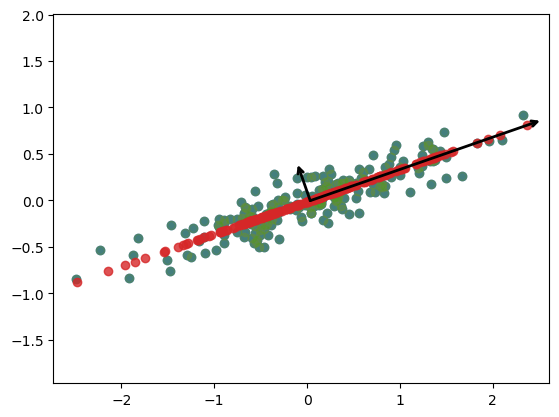

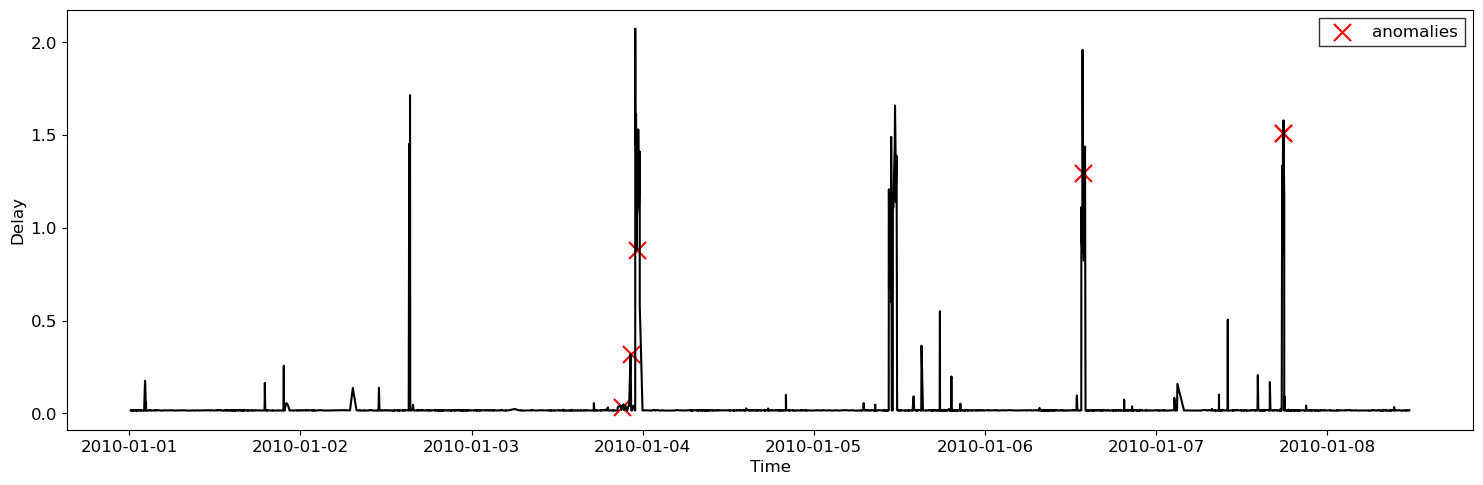

In [30]:
# TEST FUNCTION: Trigger duration scheme
apd = APD(dataset=df)
anomalies = apd.detect()

# 2. visulize anomlies
visualize_anomalies(anomalies, df)

In APD, we have learned how to detect anomalies in single trace as shown in figure above. But, it cannot tell it is a correlated or uncorrelated anomalies. However, in network-wide anomaly detection, the correlated anomalies are more important than uncorrelated anomalies. In next section, we will learn how to use PCA-APD to detect correlated.

## 4 - PCA-APD  ##

In this section, we will learn using PCA-APD to detect correlated anomalies and uncorrelated anomalies from multiple measurement traces. 

- Correlated anomalies are anomalies occurred at the same time in different traces;
- Uncorrelated anomalies are anomalies that occurred at a certain time at a single trace. 

####  Why do we need to detect correlated anomalies?

Correlated anomalies are usually more important than the uncorrelated anomaly. Because, uncorrelated anomalies maybe some random events that occurred at a single trace, which won't have an impact on the whole network. However, the correlated anomalies occur in multiple traces at the same time, which will cause some impacts on the whole network, and it is very helpful for root-cause analysis.

The basic idea of PCA-APD algorithms is to use SVD to separate the correlated anomalies and uncorrelated anomalies from multiple traces into difference subspaces. After separating correlated and uncorrelated anomalies into different subspace, we can just use our APD algorithm to detect those correlated anomalies. 


The exact steps for PCA-APD algorithm are as follows:
    1. Apply PCA algorithm to multiple traces to capture first K (K=1,2,3) components, and the K >> N (the number of measurements). In our paper, we have shown that the correlated anomalies have a higher probability to be captured in the first K (K=1,2,3) components. And, uncorrelated anomalies may be captured in the rest of the components;
    2. Project measurements into first K components;
    3. Apply the APD algorithm to projected measurements for detecting correlated anomalies.
    
(Note: in our orginal paper, we use PCA algoirthm in Matlab for anomaly detection. In this tutorial, we use SVD algorithm, which is simpler and performs similarly as PCA). 

### 4.1 - Prepare the datasets 

First, we need to prepare our datasets. There are 10 measurements traces used in this tutorial. And, we need to load these 10 traces to construct the a measurement matrix $A$.

In [34]:

traces_path = [ os.getcwd() + '/traffic_dataset/time_series_1.csv',  os.getcwd() + '/traffic_dataset/time_series_2.csv',  os.getcwd() + '/traffic_dataset/time_series_3.csv',
                os.getcwd() + '/traffic_dataset/time_series_4.csv',  os.getcwd() + '/traffic_dataset/time_series_5.csv',  os.getcwd() + '/traffic_dataset/time_series_6.csv',
                os.getcwd() + '/traffic_dataset/time_series_7.csv',  os.getcwd() + '/traffic_dataset/time_series_8.csv',  os.getcwd() + '/traffic_dataset/time_series_9.csv',
                os.getcwd() + '/traffic_dataset/time_series_10.csv']

traces_name = ['trace-1', 'trace-2', 'trace-3', 'trace-4', 'trace-5', 
               'trace-6', 'trace-7', 'trace-8', 'trace-9', 'trace-10']

traces_df = list()

for i, path in enumerate(traces_path):
    # load meassurement into pandas dataframe
    df = pd.read_csv(path, header=0, parse_dates=[0])
    
    # Change the index to timstampe
    df = df.set_index(['ts'])
    
    # remove index name
    df.index.name = None
    
    # append each dataframe to the list
    traces_df.append(df)

# concatenate all dataframe to a large dataframe, which is 3000 * 10
A = pd.concat(traces_df, axis=1)
A.columns = traces_name
A

,trace-1,trace-2,trace-3,trace-4,trace-5,trace-6,trace-7,trace-8,trace-9,trace-10
2020-01-01 00:00:00,1.012197,1.170083,1.067559,1.125527,1.045344,0.971943,0.966823,0.866229,0.868691,1.136403
2020-01-01 00:05:00,0.768386,0.926272,0.823748,0.881716,0.801533,0.728132,0.723012,0.622418,0.624880,0.892592
2020-01-01 00:10:00,0.871813,1.029699,0.927175,0.985143,0.904960,0.831559,0.826439,0.725845,0.728307,0.996019
2020-01-01 00:15:00,1.097437,1.255323,1.152799,1.210767,1.130584,1.057183,1.052063,0.951469,0.953931,1.221643
2020-01-01 00:20:00,1.030700,1.188586,1.086062,1.144030,1.063847,0.990446,0.985326,0.884732,0.887194,1.154906
...,...,...,...,...,...,...,...,...,...,...
2020-01-11 09:35:00,0.878165,1.036051,0.933527,0.991495,0.911312,0.837911,0.832791,0.732197,0.734659,1.002371
2020-01-11 09:40:00,0.868143,1.026029,0.923505,0.981473,0.901290,0.827889,0.822769,0.722175,0.724637,0.992349
2020-01-11 09:45:00,0.829583,0.987469,0.884945,0.942913,0.862730,0.789329,0.784209,0.683615,0.686077,0.953789
2020-01-11 09:50:00,0.682169,0.840055,0.737531,0.795499,0.715316,0.641915,0.636795,0.536201,0.538663,0.806375


As shown in the table above, the measurement matrix $A$ is $m \times n$ matirx, which has 3000 rows and 10 columns; each column denotes a single trace, and each row denotes a certain timestamp.

### 4.2 - Dimensional reduction through rank-$k$ approximations

Lower rank-$k$ approximations is to find lower rank-$k$ ($k < n$) to approximate original high dimensional dataset $A$. Here, we use the Singular Value Decomposition (SVD) to achieve it. (Note, we can use PCA as well).

For an $m\times n$ matrix $A$, the SVD does two things:

1. It gives the best rank-$k$ approximation to $A$ for __every__ $k$ up to the rank of $A$.
2. It gives the __distance__ of the best approximation $A^{(k)}$ from $A$ for each $k$.


The singular value decomposition of a rank-$r$ matrix $A$ has the form:

$$A = U\Sigma V^T$$

where,

1. Here $r$ is full rank
2. $U$ is $m\times r$
3. The columns of $U$ are mutually orthogonal and unit length, ie., $U^TU = I$.
4. $V$ is $n\times r$.
5. The columns of $V$ are mutually orthogonal and unit length, ie., $V^TV = I$.
6. The matrix $\Sigma$ is a $r\times r$ diagonal matrix, whose singular values are $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_r > 0$.

In terms of the singular value decomposition, 

1) The distance (in Frobenius norm) of the best rank-$k$ approximation $A^{(k)}$ from $A$ is equal to $\sqrt{\sum_{i=k+1}^r\sigma^2_i}$.

2) The best rank-$k$ approximation to $A$ is formed by taking 

* $U' = $ the $k$ leftmost columns of $U$, 
* $ \Sigma' = $ the $k\times k$ upper left submatrix of $\Sigma$, and 
* $V'= $ the $k$ leftmost columns of $V$, and constructing 

$$ A^{(k)} = U'\Sigma'(V')^T.$$

#### Let's find the best k for approximations

We can plot the singular value $\Sigma$, and each $\sigma_k$ descirbes the importance of singular vector $u_k$ and $v_k$.

In [38]:
u,s,vt = np.linalg.svd(A)
r = len(s)
fig = plt.figure(figsize=(7,5))
plt.plot(range(1,1+r),s)
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'$\sigma_k$',size=20)
plt.title(r'Singular Values of $A$',size=20)
print('')

In [39]:
# transform it into ratio
fig = plt.figure(figsize=(7,5))
Anorm = np.linalg.norm(A)
plt.plot(range(1,r + 1),s[0:r]/Anorm)
plt.xlim([0,r + 1])
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'$\sigma_k$',size=20)
print('')
s[0:r]/Anorm

array([0.98821495, 0.06673745, 0.0616659 , 0.05836528, 0.05475714,
       0.04893351, 0.04762743, 0.03959735, 0.0387819 , 0.0321706 ])

The figure above shows the singular value $\sigma_1$ is much more important than others.

### 4.3 - Components and Subspace Analysis

In this part, we need detect correlated anomalies. In other words, we need to classify our anomalies into correlated anomalies and uncorrelated anomalies. Lower rank-$k$ approximation (or first K components) can capture common patterns of traffic (or normal traffic). These components form a subspace defined as __normal subspace__.  Anomalies captured in the rest of the components are defined as __anomalous subspace__. In our paper [DRCN2015], we have also demonstrated that the correlated anomalies can be also captured in the __normal subspace__.

Let's go through with SVD to understand better of this definition. With SVD, the matrix $A$ can be decomposed into: 

$$A = U\Sigma V^T$$

And lower rank-$k$ approximation can be written as

$$ A^{(k)} = U^{(k)}\Sigma^{(k)}(V^{(k)})^T.$$

where the $k < r$, $r$ is the number of full rank, the $U^{(k)} = \{u_1, ..., u_k\}$, $V^{(k)} = \{v_1, ..., v_k\}$, and $\Sigma^{(k)} = \{\sigma_1, ..., \sigma_k\}$ where $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_k > 0$. Each $u_i$ can be understand as a component, and combinations of $u_i$ construct the subspaces.  

We can plot these components to visualize different patterns in different components $u_i$ or different subspace.

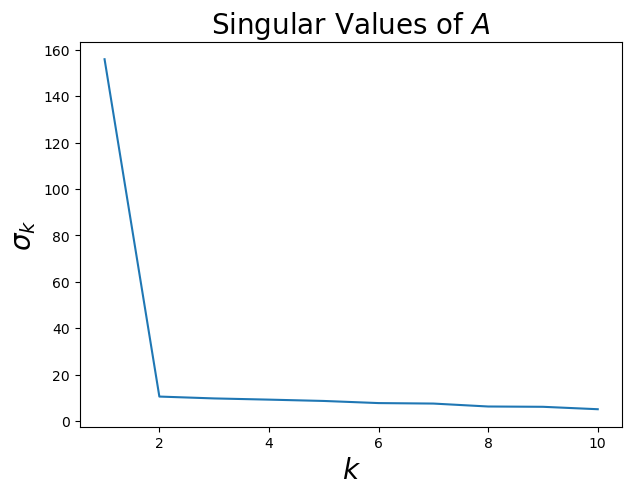

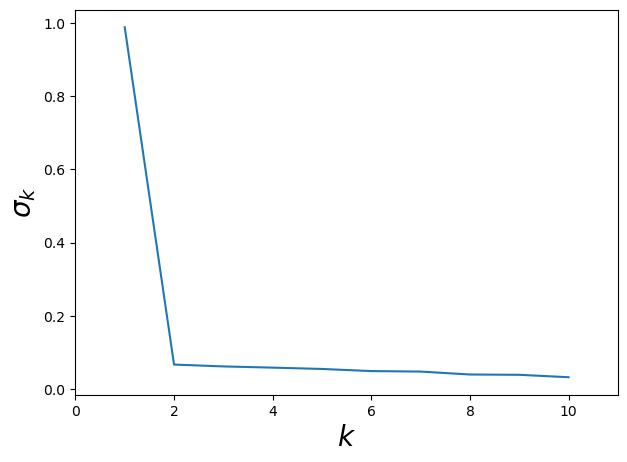

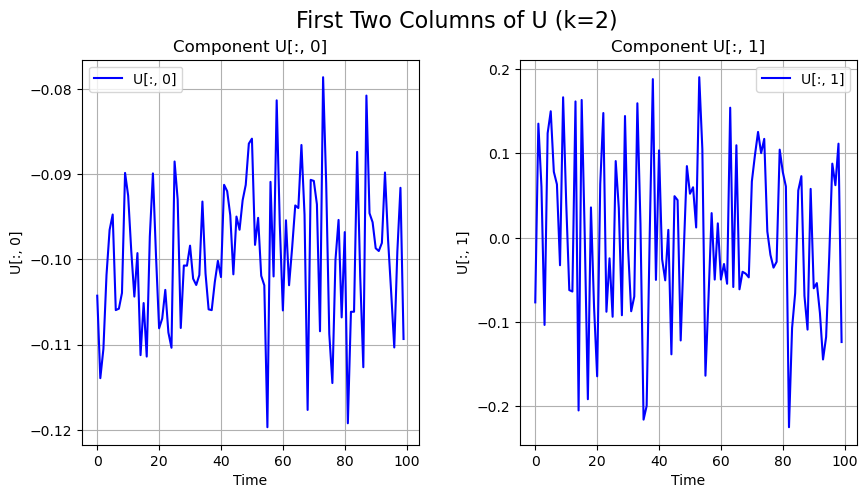

In [43]:
A = np.random.rand(100, 50)  # Example dataset with 100 rows and 50 columns

# Perform Singular Value Decomposition
U, S, VT = np.linalg.svd(A, full_matrices=False)

# Plot the first two columns of U (k=2)
plt.figure(figsize=(10, 5))
for i in range(2):  # Loop over the first 2 components
    plt.subplot(1, 2, i + 1)  # Create a 1x2 grid for the two components
    plt.plot(U[:, i], label=f'U[:, {i}]', color='blue')
    plt.xlabel('Time', fontsize=10)
    plt.ylabel(f'U[:, {i}]', fontsize=10)
    plt.title(f'Component U[:, {i}]', fontsize=12)
    plt.grid(True)
    plt.legend()

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.3)
plt.suptitle('First Two Columns of U (k=2)', size=16)
plt.show()

The figure above shows that the traffic captured by the first component $u_1$ is considered a normal pattern. Because it looks more regular than others. However, in $u_i$ we can also find there are __three__ obvious dips captured in $u_1$, which are considered as correlated anomalies. In other components $\{u_2, ..., $u_6\}$, we can observe that the pattern is not regular that has random spikes and dips, which are uncorrelated anomalies.

#### Conclusion

SVD (or PCA) can effectively help us to separate traffic into __normal subspace__ and __anomalous subspace__. 

- __normal subspace__ : is formed by first $k$ components, correlated anomalies are located at normal subspace
- __anomalous subspace__: is formed by rest of components, uncorrelated anomalies are located at anomalous subspace.

After separating our traffic matrix $A$ into different subspaces, we can detect relevant anomalies in different subspace using our APD algorithms. Please note that the correlated anomalies can be also captured in anomalous subspace sometimes. But, because we know the which is correlated anomalies in normal subspace, we can easily eliminate them.

### 4.4 Correlated Anomaly detection in subspace

In the last section, we have learned using the low-rank phenomenon to separate anomalous data from the population of normal data. We also learned the concept of subspaces, and how to use SVD to map measurement matrix into __normal subspace__ and __anomalous subspace__. In this section, we will learn how to detect correlated anomalies and uncorrelated anomalies in different subspaces. 

In practice, here are the basic steps,

Given a traffic matrix $A$, we have the following steps:

1.  Compute the Singular value decomposition (SVD) of $A$, $$A = U\Sigma V^T$$ 
<br /> 

2.  Choose suitable $k$ for low-rank $k$ approximation to separate traffic into normal subspace and anomalous subspace
<br /> 


3.  Compute normal traffic matrix $N$ can be constructed by using normal subspace $U^{(k)}$, $$N = U^{(k)}\Sigma^{(k)} (V^{(k)})^T$$ <br /> 

4.  Compute anomalous traffic matrix $M$:  $$M = A-N$$
<br /> 

5.  Detect correlated anomalies using normal traffic matrix $N$, and detect uncorrelated anomalies using anomalous traffic matrix $M$

__Step 1__ and __step 2__ are finised in Section 4.3, and we choose $k=3$ for construct our __normal subspace__.

__Step 3__: compute our normal traffic matrix $N$, and plot the normal traffic $N$ with its $\ell_2$ norm

In [64]:
unormal = u[:,0:3]            # normal subspace
snormal = s[0:3]
vnormal = vt[0:3,:]
N = np.dot(np.dot(unormal, np.diag(snormal)), vnormal)
Nnorm = np.linalg.norm(N,axis=1)
plt.plot(Nnorm)
plt.xlabel('Time')
plt.title(r'$\ell_2$ Norm of Normal Traffic')

print(' ')

From the figure above, we can observe that there are three correlated anomalies occurred in normal traffic.

__Step 4__: compute our anomalous traffic matrix $M$, and plot the anomalous traffic $M$ with its $\ell_2$ norm

Shape of A: (100, 50)
Shape of N: (100, 10)


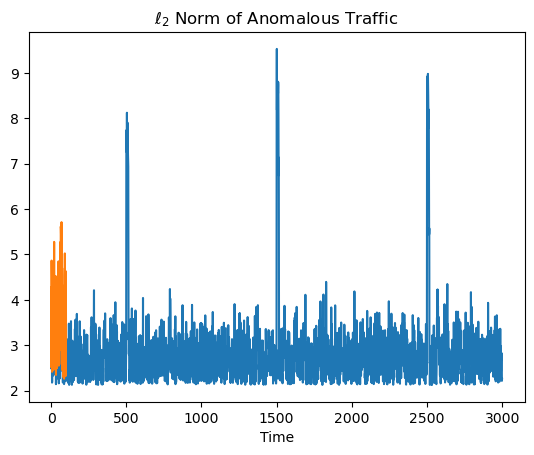

In [69]:
# Ensure A and N are numpy arrays
A = np.array(A)
N = np.array(N)

# Check shapes
print(f"Shape of A: {A.shape}")
print(f"Shape of N: {N.shape}")

# Tile N to match A's shape if N has fewer columns
if N.shape[1] < A.shape[1]:
    N = np.tile(N, (1, A.shape[1] // N.shape[1]))

# Check if tiling worked, and slice if necessary to match exactly
if N.shape != A.shape:
    N = N[:, :A.shape[1]]

# Compute the anomalous traffic matrix M
M = A - N

# Handle NaN values in M (if necessary)
M = np.nan_to_num(M)

# Compute the L2 norm of M along axis 1
Annorm = np.linalg.norm(M, axis=1)

# Plotting the result
plt.plot(Annorm)
plt.xlabel('Time')
plt.title(r'$\ell_2$ Norm of Anomalous Traffic')
plt.show()

The figure "$\ell_2$ Norm of Anomalous Traffic" shows that there are many uncorrelated anoamlies occurred.

__Step 5__: Detect correlated anomalies using normal traffic matrix $N$, and detect uncorrelated anomalies using anomalous traffic matrix $M$.

When we get normal traffic matrix $N$ and relevant $\ell_2$ norm form $Nnorm$, which is one-dimensional dataset, we can just detect correlated anomalies with our APD algorithm.

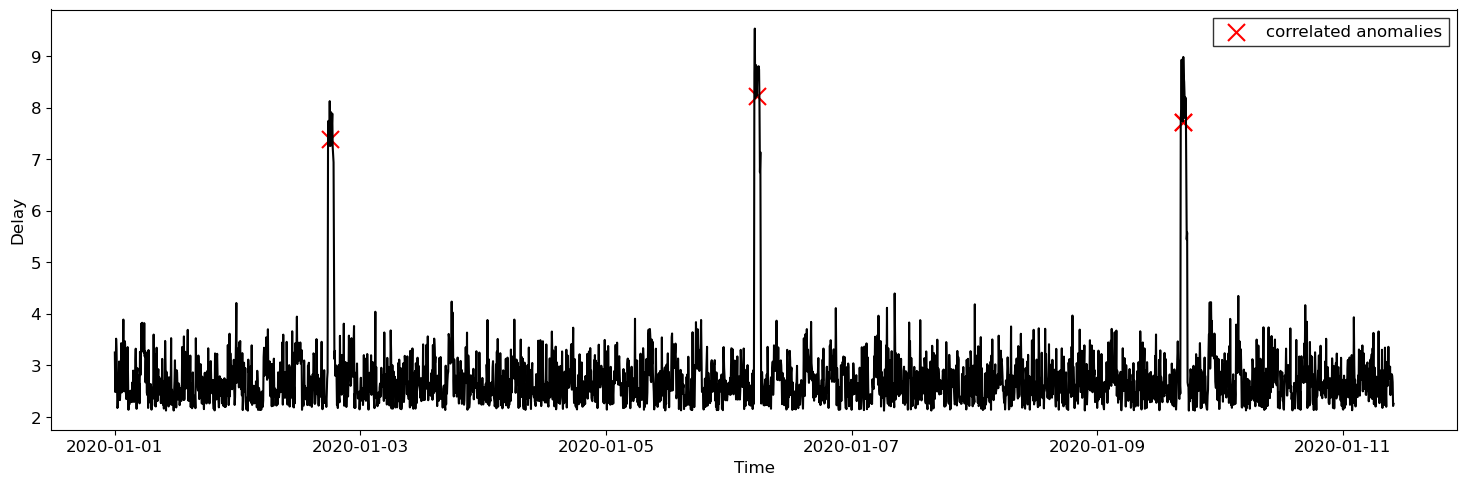

In [73]:
# construct Nnorm dataframe Nnorm_df
Nnorm_df = pd.DataFrame(Nnorm, index=pd.date_range('1/1/2020', freq='5min', periods=3000), columns=['delay'])

# TEST FUNCTION: Trigger duration scheme
apd = APD(dataset=Nnorm_df)
anomalies = apd.detect()

# 2. visulize anomlies
visualize_anomalies(anomalies, Nnorm_df, 'correlated anomalies')

When we get anomalous traffic matrix $M$ and its $\ell_2$ norm form $Annorm$, we can just detect uncorrelated anomalies with our APD algorithm.

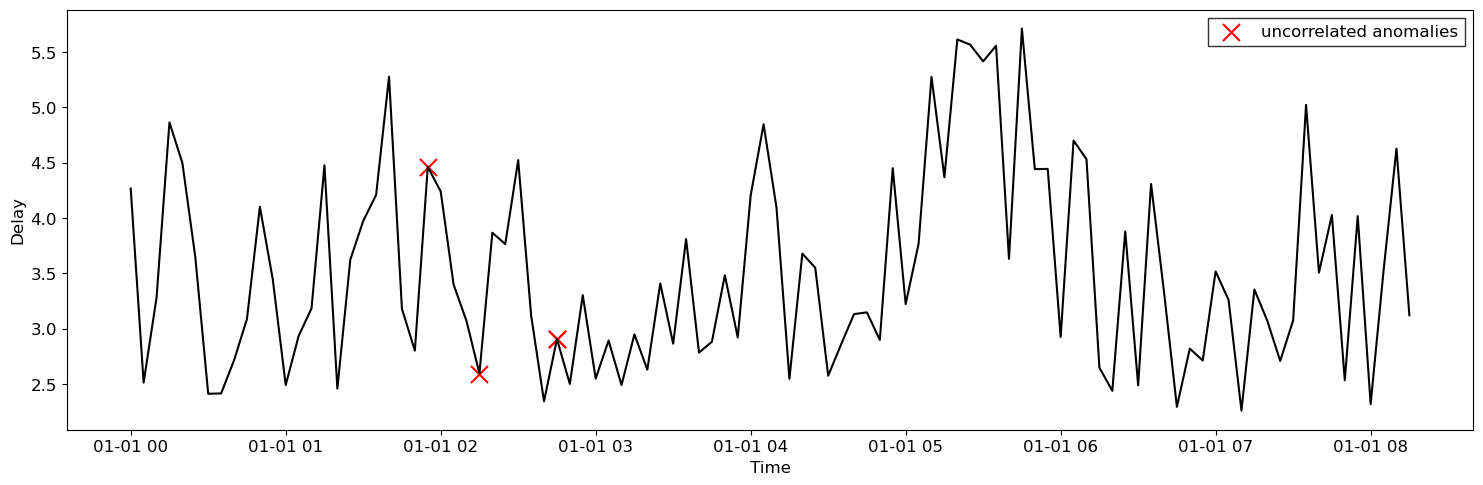

In [78]:
# Adjust the date range to match the length of Annorm
Annorm_df = pd.DataFrame(Annorm, index=pd.date_range('1/1/2020', freq='5min', periods=100), columns=['delay'])

# TEST FUNCTION: Trigger duration scheme
apd = APD(dataset=Annorm_df)
anomalies = apd.detect()

# 2. visulize anomlies
visualize_anomalies(anomalies, Annorm_df, 'uncorrelated anomalies')

### 4.5-Conclusion

Congrats on finishing this homework about using the idea of dimensional reduction (PCA or SVD) for anomaly detection, understanding the basic theory of low-rank approximation, the concept of subspace, and how to combine SVD and APD to detect correlated and uncorrelated anomalis.

## Questions:
1. Explain the concept of __correlated__ and __uncorrelated__ anomalies in network-wide anomaly detection, and why is the correlated anomalies are more important?
2. Explain the concept __normal subspace__ and __anomalous subspace__, explain how to get these two subspaces, and the purpose of the subspace in anomaly detection?
3. In our tutorial, we use $k=3$ to separate __normal subspace__ and __anomalous subspace__, please re-produce all the figures in Section 4.3 and section 4.4 using $k=2$. Please submit your executable jupyter notebook file (*.ipynb) with the outputs.